# <font size=6>**Assignment_4. Time series analysis**

<font size=2>*TP Authors : Chen Yuheng, Zhou Ziang*    

---







# 0. Load debit card dateset and import library

In [5]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from pandas import DataFrame

from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Display data and comment

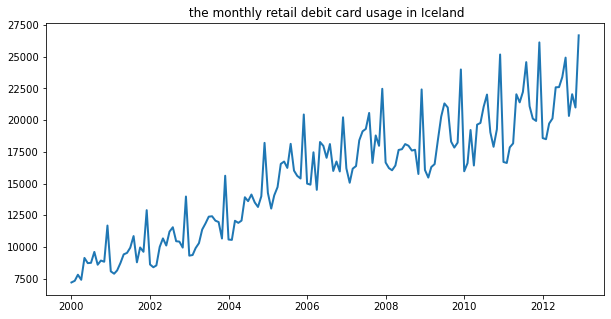

the time series is not stationary and the p-value = 0.7881064417185544, so we can not reject hypothesis


In [3]:
# display the data
ts = pd.read_csv("OneDrive/文档/UTC_A21_ARS/AOS1/debitcards.csv",index_col=0,parse_dates=True)
ts.index.freq="MS"
plt.figure(figsize=(10,5))
plt.rc('lines', linewidth = 2) 
plt.plot(ts)
plt.title(" the monthly retail debit card usage in Iceland")
plt.show()

# stationarity test
def judge_stationarity(time_series):   
  time_series = adf(time_series,autolag="AIC")
  # since the stationary time series' p-value is almost equal to 0, we set threshold 10^-3 to discriminate
  if time_series[1] > 0.05:
    print("the time series is not stationary and the p-value = " +str(time_series[1]) +', so we can not reject hypothesis')
  else:
    print("the time series is stationary because the p-value < 0.05")

judge_stationarity(ts)


The data stores the monthly retail debit card usage in Iceland, so as we can see that the correlation between **the same months of each year** is very important. At the same time, we can see that this time series has an upward trend and seasonal component(**unstationarity**) which can be interpreted as inflation, developement of economic levels and festival factor. In the figure, we can also note the reduction in people's consumption level caused by the global economic crisis in 2008.

we can also valide the nonstationarity by ADF test.

# 2. Model selection and parameters determination

We can clearly see in the displayed data that our data contains three components:

*   Seasonal component
*   Trend
*   noise/residual  

So the **SARIMAX** model is more suitable to match our data, which means that we have to determine the parameters for the three components:


*   Seasonal component $\to$ seasonal_order(p,d,q,m)
*   Trend $\to$ degree of trend
*   noise/residual(order) $\to$ order(p,d,q)

Basically, our approach to determine the parameters can be summarized as follows:
1. Seasonal decomposition to determine degree of trend and m in seasonal component
2. Differencing operation to make our time series stationary and determine d in order parameter
3. By analyzing the result of ACF and PACF and fixing d=1, we analyze and get (p,q)
4. With determined order parameter(p,d,q), we traverse all the seasonal_order parameter combination (p,d,q,12) for the seasonal component. Then we select the best combination (p,d,q,12) which gives us the best AIC.






---



## 1. Trend, seasonal_order(m)
We first do the seasonal decomposition, because the decomposed data can help us quickly determine the period of the seasonal component and the order of the trend

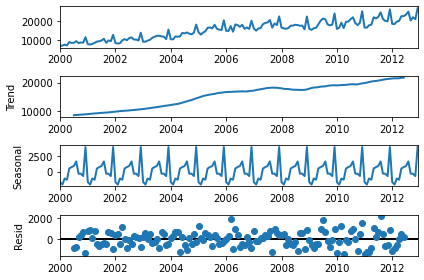

In [6]:
# seasonal decomposition
# type of decomposition is not very important in our case, since we don't use the three parts to compute
decomposition = seasonal_decompose(ts,model="additive") 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# display the result of decompositoin
decomposition.plot()
plt.show()

As we can see in the seasonal decomposition, the seasonal component has a period of 12 months. So the we will set the seasonal_component parameter **m = 12**. Besides, we note that the trend is almost linear, so the trend parameter in the SARIMAX model will be set to **'t'**



---



## 2. order(d)
And then, we need to **make our time series stationary** before all the processing and analyzing. So the differencing operation will be used.

In [7]:
# use one-step and one term differencing operation
ts_diff = ts.diff().dropna()

ts_test = adf(ts_diff.iloc[:,0].values)
tsoutput = pd.Series(
        ts_test[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
for key, value in ts_test[4].items():
    tsoutput["Critical Value (%s)" % key] = value
print(tsoutput)

Test Statistic                  -2.966366
p-value                          0.038157
#Lags Used                      13.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


After one-step differencing operation, the p-value has reduced to 0.038 < 0.05 which means the time-series is stationary. So in the SARIMAX model the order parameter will be set to **d = 1**



---



## 3. order(p,q)

We would like to travse all the order(p,d,q) possible combinations to determine the best one, but the compution too costly. So by analyzing the PACF and ACF, we can reduce the possible combination so that it takes less time to compute.

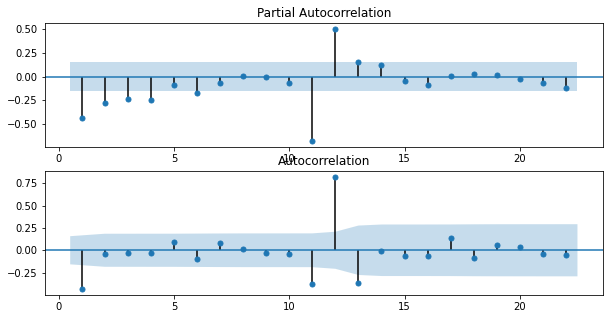

In [ ]:
# ACF and PACF
fig, ax = plt.subplots(2, figsize=(10, 5))
plot_pacf(ts_diff,method='ywm',zero=False,ax =ax[0])
plot_acf(ts_diff,zero=False,ax =ax[1])
plt.show()

From the plot of pca and pacf,we world like to choose p=4 and q=1 as the parameters of the ARIMA. We can also use arma_order_select_ic to iterate the model with different p and q to choose the best parameter with the AIC and BIC. 

In [ ]:
'''
#AIC
AIC = sm.tsa.arma_order_select_ic(ts_diff,\
max_ar=8,max_ma=8,ic='aic')['aic_min_order']
#BIC
BIC = sm.tsa.arma_order_select_ic(ts_diff,max_ar=8,\
max_ma=8,ic='bic')['bic_min_order']
#HQIC
HQIC = sm.tsa.arma_order_select_ic(ts_diff,max_ar=8,\
max_ma=8,ic='hqic')['hqic_min_order']
print('the AIC is{},\nthe BIC is{}\n the HQIC is{}'.format(AIC,BIC,HQIC))
'''

In [ ]:
smx = sarimax(ts,order=(4,1,1)).fit()
print(smx.summary())

                           Statespace Model Results                           
Dep. Variable:                     V1   No. Observations:                  156
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1401.009
Date:                Fri, 22 Oct 2021   AIC                           2814.018
Time:                        21:42:44   BIC                           2832.279
Sample:                    01-01-2000   HQIC                          2821.435
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0409      0.190     -0.215      0.829      -0.413       0.332
ar.L2         -0.1052      0.141     -0.747      0.455      -0.381       0.171
ar.L3         -0.1100      0.105     -1.043      0.2

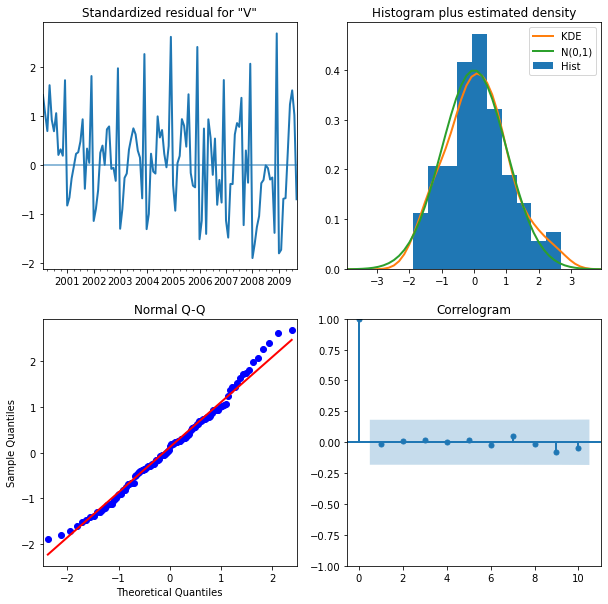

In [10]:
# train the test model and see the result
ts_train = ts[:int(ts.shape[0]*0.75)]
ts_test = ts[int(ts.shape[0]*0.75):]

smx = sarimax(ts_train,order=(4,1,1),trend='t').fit()
plt.rc("figure", figsize=(10,10))
smx.plot_diagnostics()
plt.show()

As we can see in the diagnostic plot, the residual part is almost a white noisy, so the all information can be considered extracted(we ignore the seasonal information here)

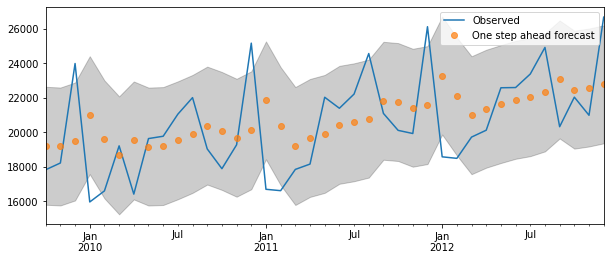

In [ ]:
# we train the model with all the data
model_test = sarimax(ts, order=(4, 1, 1),trend='t')
model_test_res = model_test.filter(smx.params)
pred = model_test_res.get_prediction(start = int(ts.shape[0]*0.75))
pred_ci=pred.conf_int()

ax = ts_test.plot(y="V1",label="Observed",figsize=(10,4))
pred.predicted_mean.plot(ax=ax,label="One step ahead forecast",alpha=0.7,linestyle='',marker='o')
ax.fill_between(pred_ci.index,pred_ci['lower V1'],pred_ci['upper V1'],color="k",alpha=0.2)
plt.legend()

The predicted results don't match the real data so well, so we can say that the seasonal part is necessary to be modeled

In [ ]:
# compute error 
MSE = np.mean((pred.predicted_mean-ts_test.V1)**2)
MSE

7014711.279929862

## 4. seasonal_order(p,d,q)
With determined order parameter(p,d,q), we traverse all the seasonal_order parameter combination (p,d,q,12) for the seasonal component. Then we select the best combination (p,d,q,12) which gives us the best AIC.
We fix d=1 here to simplify iteration 

In [ ]:
# iteration to all the possible (p,d,q) combinations
from itertools import product
p = q = range(0, 9, 1)
d=1
pdq = list(product(p,q))
seasonal_pdq = [(x[0], d, x[1], 12) for x in list(product(p, q))]

results = []

for param_seasonal in seasonal_pdq:
    try:
        mod = sarimax(ts,
                      order=(4,1,1),
                      seasonal_order=param_seasonal,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

        mod_results = mod.fit()
        results.append([param_seasonal, mod_results.aic, mod_results.bic])

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [ ]:
# visualize the AIC resault
df = pd.DataFrame(results,columns=['param_seasonal', 'AIC', 'BIC'])
df.sort_values('AIC')

,param_seasonal,AIC,BIC
33,"(8, 1, 1, 12)",728.048808,754.466809
32,"(8, 1, 0, 12)",729.191258,753.848060
34,"(8, 1, 2, 12)",732.324836,760.504038
30,"(7, 1, 2, 12)",920.713985,950.823983
29,"(7, 1, 1, 12)",923.157950,951.260615
28,"(7, 1, 0, 12)",924.790555,950.885887
25,"(6, 1, 1, 12)",1118.679329,1147.340333
26,"(6, 1, 2, 12)",1120.332926,1151.198623
24,"(6, 1, 0, 12)",1124.058952,1150.515263
20,"(5, 1, 0, 12)",1321.195716,1347.259643


Therefore, the combination (8,1,1,12) is chosen to fit our model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


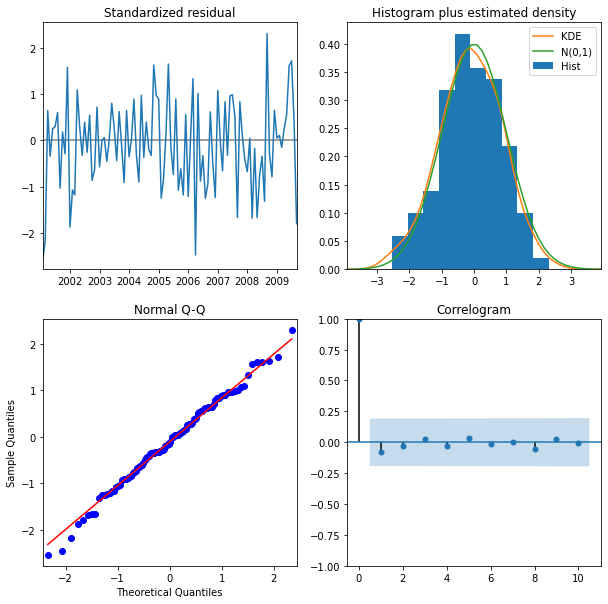

In [ ]:
# plot diagnostics of our model to valide
smx = sarimax(ts_train,order=(4,1,1),seasonal_order=(8,1,1,12),trend='t').fit()
plt.rc("figure", figsize=(10,10))
smx.plot_diagnostics()
plt.show()

Same as before, the residual part is almost a white noisy, so the all information can be considered extracted

However, our test model has not consider all the information(especially the 2008 global financial crisis), so we retrain another model with all the dataset

C:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


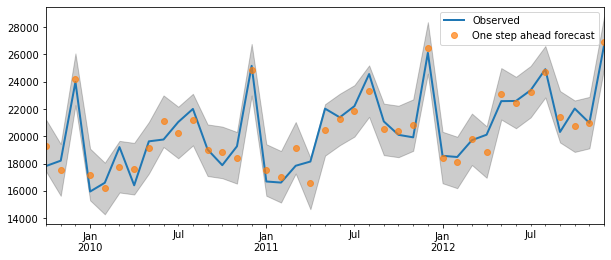

In [11]:
# trian another model with all the data
smx = sarimax(ts,order=(4,1,1),seasonal_order=(8,1,1,12),trend='t').fit()

model_test = sarimax(ts, order=(4, 1, 1),seasonal_order=(8,1,1,12),trend='t')
model_test_res = model_test.filter(smx.params)
pred = model_test_res.get_prediction(start = int(ts.shape[0]*0.75))
pred_ci=pred.conf_int()

ax = ts_test.plot(y="V1",label="Observed",figsize=(10,4))
pred.predicted_mean.plot(ax=ax,label="One step ahead forecast",alpha=0.7,linestyle='',marker='o')
ax.fill_between(pred_ci.index,pred_ci['lower V1'],pred_ci['upper V1'],color="k",alpha=0.2)
plt.legend()

In [ ]:
# compute error
MSE = np.mean((pred.predicted_mean-ts_test.V1)**2)
MSE

734962.7751636504

The predict result match better than before, and the error has been greatly decresed, so it is the model we use to predict 

#3. Prediction

With all the determined parameters, we train our SARIMAX model and predict the futur four months' data

In [ ]:
model_test = sarimax(ts, order=(4, 1, 1),seasonal_order=(8,1,1,12),trend='t')
model_test_res = model_test.filter(smx.params)
pred = model_test_res.get_prediction(start = '2013-01-01',end= '2013-04-01')
pred.summary_frame()

V1,mean,mean_se,mean_ci_lower,mean_ci_upper
2013-01-01,19412.405544,959.595111,17531.633687,21293.177402
2013-02-01,19020.917519,1046.268599,16970.268746,21071.566292
2013-03-01,20022.782456,1091.282511,17883.908036,22161.656875
2013-04-01,20066.388287,1192.578534,17728.977311,22403.799263


C:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


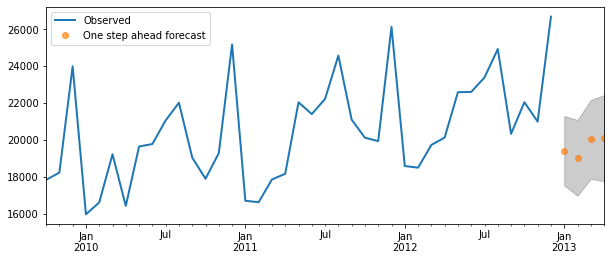

In [13]:
# display predicted data and origin data
smx = sarimax(ts,order=(4,1,1),seasonal_order=(8,1,1,12),trend='t').fit()

model_test = sarimax(ts, order=(4, 1, 1),seasonal_order=(8,1,1,12),trend='t')
model_test_res = model_test.filter(smx.params)
pred = model_test_res.get_prediction(start = '2013-01-01',end= '2013-04-01')
pred_ci=pred.conf_int()

ax = ts_test.plot(y="V1",label="Observed",figsize=(10,4))
pred.predicted_mean.plot(ax=ax,label="One step ahead forecast",alpha=0.7,linestyle='',marker='o')
ax.fill_between(pred_ci.index,pred_ci['lower V1'],pred_ci['upper V1'],color="k",alpha=0.2)
plt.legend()

## Normalization(to evaluate the performance of model)
The MSE can't clearly show the performance of the model, so we'll scale the data and fit again the data

In [ ]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaled_ts = MinMaxScaler((-1,1)).fit_transform(ts)
scaled_ts = DataFrame(scaled_ts,index=ts.index)
scaled_ts.rename(columns={0:'V1'},inplace=True)
scaled_ts

,V1
2000-01-01,-1.000000
2000-02-01,-0.986544
2000-03-01,-0.937548
2000-04-01,-0.978532
2000-05-01,-0.801551
...,...
2012-08-01,0.819732
2012-09-01,0.347748
2012-10-01,0.523702
2012-11-01,0.415849


In [ ]:
# splite data into training set and test set
scaled_ts_train = scaled_ts[:int(ts.shape[0]*0.75)]
scaled_ts_test = scaled_ts[int(ts.shape[0]*0.75):]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


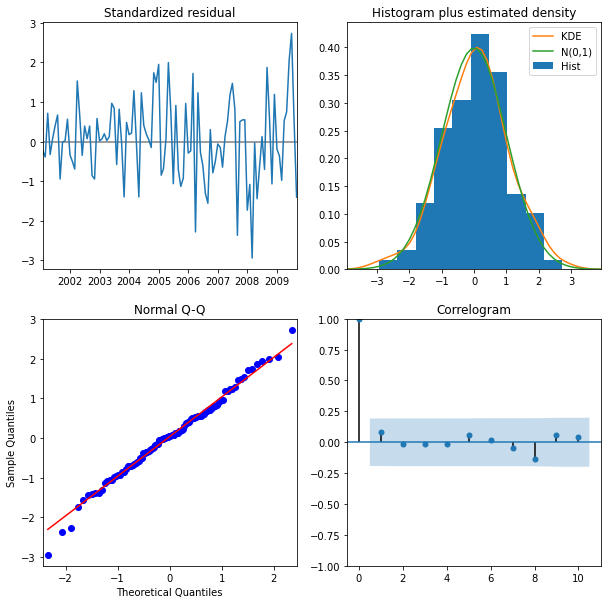

In [ ]:
smx = sarimax(scaled_ts_train,order=(4,1,1),seasonal_order=(8,1,1,12),trend='t').fit()
plt.rc("figure", figsize=(10,10))
smx.plot_diagnostics()
plt.show()

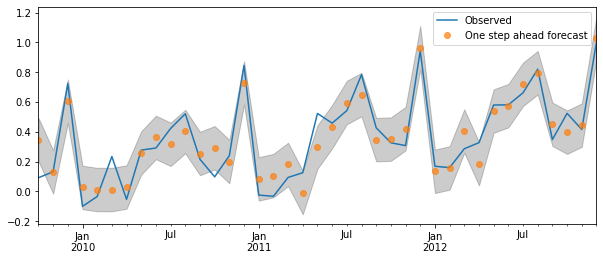

In [ ]:
# train model with normalized time series
model_test = sarimax(scaled_ts, order=(4,1,1),seasonal_order=(8,1,1,12),trend='t')
model_test_res = model_test.filter(smx.params)
pred = model_test_res.get_prediction(start = int(ts.shape[0]*0.75))
pred_ci=pred.conf_int()

ax = scaled_ts_test.plot(y="V1",label="Observed",figsize=(10,4))
pred.predicted_mean.plot(ax=ax,label="One step ahead forecast",alpha=0.7,linestyle='',marker='o')
ax.fill_between(pred_ci.index,pred_ci['lower V1'],pred_ci['upper V1'],color="k",alpha=0.2)
plt.legend()

In [ ]:
# compute error normalized
MSE = np.mean((pred.predicted_mean-scaled_ts_test.V1)**2)
MSE

0.011719179983464832

The error shows that our modeling is acceptable